In [7]:
pip install botorch

In [4]:
import pandas as pd
import torch

train_data = pd.read_excel('data_sample_multiple_components_GLU_9objs.xlsx')
#print(train_data)
train_x = train_data.iloc[:,[1]].values
#print(train_X)
train_x = torch.tensor(train_x, dtype=torch.float32)
print(train_x)

train_obj = train_data.iloc[:,[2]].values
#print(train_Y)
train_obj = torch.tensor(train_obj, dtype=torch.float32)
print(train_obj)

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000]])
tensor([[0.0450],
        [0.0390],
        [0.0470],
        [0.0430],
        [0.0500],
        [0.0510],
        [0.0490],
        [0.0500],
        [0.0550],
        [0.0530],
        [0.0420],
        [0.0500],
        [0.0420],
        [0.0490],
        [0.0430],
        [0.0440],
        [0.0480],
        [0.0480],
        [0.0640],
        [0.0530],
        [0.0560],
        [0.0570],
        [0.0620],
        [0.0580]])


In [5]:
import math
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [6]:
# initialize the model using SingleTaskGP (L-BFGS-B)

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan

model = SingleTaskGP(train_X=train_x, train_Y=train_obj)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

In [8]:
# Define marginal log likelihood

from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_x)

In [9]:
# Define optimizer and specify parameters to optimize

from torch.optim import SGD

optimizer = SGD([{'params': model.parameters()}], lr=0.1)

In [10]:
# Fit model hyperparameters and noise level

NUM_EPOCHS = 150

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_x)
    # Compute negative marginal log likelihood
    loss = - mll(output, model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
            f"noise: {model.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Epoch  10/150 - Loss: 1.656 lengthscale: 0.669 noise: 1.974
Epoch  20/150 - Loss: 1.611 lengthscale: 0.646 noise: 1.801
Epoch  30/150 - Loss: 1.562 lengthscale: 0.624 noise: 1.623
Epoch  40/150 - Loss: 1.506 lengthscale: 0.605 noise: 1.441
Epoch  50/150 - Loss: 1.443 lengthscale: 0.588 noise: 1.258
Epoch  60/150 - Loss: 1.372 lengthscale: 0.572 noise: 1.077
Epoch  70/150 - Loss: 1.290 lengthscale: 0.558 noise: 0.899
Epoch  80/150 - Loss: 1.196 lengthscale: 0.546 noise: 0.730
Epoch  90/150 - Loss: 1.090 lengthscale: 0.534 noise: 0.575
Epoch 100/150 - Loss: 0.969 lengthscale: 0.524 noise: 0.438
Epoch 110/150 - Loss: 0.835 lengthscale: 0.515 noise: 0.324
Epoch 120/150 - Loss: 0.688 lengthscale: 0.507 noise: 0.232
Epoch 130/150 - Loss: 0.530 lengthscale: 0.500 noise: 0.162
Epoch 140/150 - Loss: 0.364 lengthscale: 0.493 noise: 0.110
Epoch 150/150 - Loss: 0.191 lengthscale: 0.486 noise: 0.074


In [11]:
# set model (and likelihood)
model.eval();

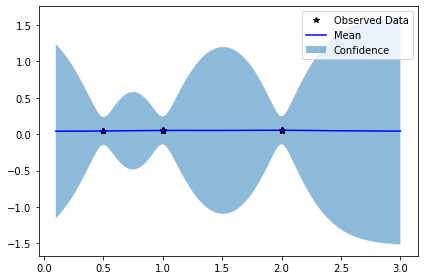

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0.1, 3]
test_X = torch.linspace(0.1, 3, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_x.cpu().numpy(), train_obj.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()